In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import datetime
from implementations import *
from helpers import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [ ]:
# Github does not accept files above 100mb and test.csv is 104mb
# thus we upload zip whith test.csv which needs to be extracted
with zipfile.ZipFile("../data/test.csv.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
import itertools
def combinations(array2d, indeces_list_a, indeces_list_b):
    combinations = list(itertools.product(indeces_list_a, indeces_list_b))
    for comb in combinations:
        new_feature = np.array([array2d[:,comb[0]] * array2d[:,comb[1]]]).T
        array2d = np.hstack((array2d, new_feature))
    return array2d

In [ ]:
#Let's modify the data: replace -999 by -9
x_99 = x
np.putmask(x_99, x_99==-999, -9)

ratio = 0.1
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_99, y, ratio)

#tx_train_99, tr_mean_99, tr_std_99 = standardize(x_train)
#tx_test_99, te_mean_99, te_std_99 = standardize(x_test)

tx_train_99 = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_99 = np.c_[np.ones((y_test.shape[0], 1)), x_test]

#Least squares
print("\t*** LS ****")
w_LS, rmse_tr = least_squares(y_train, tx_train_99)
rmse_te = compute_RMSE(y_test, tx_test_99, w_LS)
print(rmse_te)
print(rmse_tr)

#Gradient Descent
print("\t*** GS ****")
gamma = 0.00001
max_iters = 5
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_GD, rmse_tr_GD, = least_squares_GD(y_train, tx_train_99, initial_w, max_iters, gamma)
rmse_te_GD = compute_RMSE(y_test, tx_test_99, w_GD)
print(rmse_te_GD)
print(rmse_tr_GD)

#Newton
print("\t*** N ****")
gamma = 0.00002
max_iters = 5
lambd = 0.5
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_N, rmse_tr_N = learning_by_newton_method(y_train, tx_train_99, initial_w, max_iters, gamma)
rmse_te_N = compute_RMSE(y_test, tx_test_99, w_N)
print(rmse_te_N)
print(rmse_tr_N)

#Mean of 10 folds least squares
print("\t*** CLS ****")
k_folds = 10
seed = 2
w_LS_folds, rmse_tr_CLS, rmse_te_CLS = cross_validation_LS(y, x_99, k_folds, seed)

#Mean of weights along folds
w_CLS = w_LS_folds.mean(axis=0)
w_CLS = np.reshape(w_CLS, (tx_train_99.shape[1], 1))
test_mse_CLS_mean = compute_loss(y_test, tx_test_99, w_CLS)
train_mse_CLS_mean = compute_loss(y_train, tx_train_99, w_CLS)
rmse_te_CLS_mean = np.sqrt(2*test_mse_CLS_mean)
rmse_tr_CLS_mean = np.sqrt(2*train_mse_CLS_mean)
print("-mean weights:")
print(rmse_te_CLS_mean)
print(rmse_tr_CLS_mean)

#Best weights in test results
w_CLS_best = w_LS_folds[np.argmin(rmse_te_CLS)]
w_CLS_best = np.reshape(w_CLS_best, (tx_train_99.shape[1], 1))
test_mse_CLS_best = compute_loss(y_test, tx_test_99, w_CLS_best)
train_mse_CLS_best = compute_loss(y_train, tx_train_99, w_CLS_best)
rmse_te_CLS_best = np.sqrt(2*test_mse_CLS_best)
rmse_tr_CLS_best = np.sqrt(2*train_mse_CLS_best)
print("-best weights:")
print(rmse_te_CLS_best)
print(rmse_tr_CLS_best)

#Penalized Regression
lambd = 0.5
gamma = 0.00002
max_iters = 5
print("\t**** Penalized *******")
initial_w  = np.zeros((tx_train_99.shape[1],1))
w_reg, rmse_tr_reg = reg_logistic_regression(y_train, tx_train_99, lambd, initial_w, max_iters, gamma)
rmse_te_reg = compute_RMSE(y_test, tx_test_99, w_reg)
print(rmse_te_reg)
print(rmse_tr_reg)

#kind of F1-measure
print("ratio of misclassified over total predictions: ")

y_pred_LS = predict_labels(w_CLS, tx_test_99)
f1_CLS = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("F1 CLS: {l}".format(l=1-f1_CLS))

y_pred_GS = predict_labels(w_GD, tx_test_99)
f1_GS = sum(abs(y_test-y_pred_GS))/(2*len(y_pred_GS))
print("F1 GS: {l}".format(l=1-f1_GS))

y_pred_N = predict_labels(w_N, tx_test_99)
f1_N = sum(abs(y_test-y_pred_N))/(2*len(y_pred_N))
print("F1 N: {l}".format(l=1-f1_N))

y_pred_PR = predict_labels(w_reg, tx_test_99)
f1_PR = sum(abs(y_test-y_pred_PR))/(2*len(y_pred_PR))
print("F1 PR: {l}".format(l=1-f1_PR))

In [ ]:
plt.plot(range(0,k_folds), rmse_tr_CLS)
plt.plot(range(0,k_folds), rmse_te_CLS, color='r')

In [ ]:
#plot variance and mean of test/train error of Least squares
plt.boxplot([rmse_te_CLS, rmse_tr_CLS])

In [ ]:
#***** RIDGE AND LEAST SQUARE ON POLYNOMIAL BASIS FUNCTION DATASET

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
x_square = np.zeros((x_nan.shape[0], 3*x_nan.shape[1]))

#Let's build a matrix using a polynomial basis function (power 3)
for column in range(0,x_nan.shape[1]):
    x_square[:, column] = x_nan[:, column]
    x_square[:, column+x_nan.shape[1]] = np.multiply(x_nan[:,column], x_nan[:,column])
    x_square[:, column+2*x_nan.shape[1]] = np.multiply(np.multiply(x_nan[:,column], x_nan[:,column]), x_nan[:,column])
#put back -9 instead of Nan
x_square[np.isnan(x_square)]=-9

ratio = 0.3
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_square, y, ratio)

#tx_train_square, m, s = standardize(x_train)
#tx_test_square, m, s = standardize(x_test)

tx_train_square = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_square = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.ones((tx_train_square.shape[1], 1))

#Calculate accuracy with a least square regression
w_LS_pow3, rmse_LS_pow3 = least_squares(y_train, tx_train_square)
y_pred_LS = predict_labels(w_LS_pow3, tx_test_square)
f1_LS_pow3 = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("f1 score for LS: {f}".format(f=1-f1_LS_pow3))

#calculate accuracy for different lambdas (use cross_validation_ridge() for cross folds)
lambds = np.logspace(-6, -5, 50)
best_f1 = 1000
best_lamb = 0
k_folds = 5
seed = 1
f1_mean = []
f1_std = []
for lamb in lambds:
    w_rid, r = ridge_regression(y_train, tx_train_square, lamb)
    y_pred_rid = predict_labels(w_rid, tx_test_square)
    f1_rid = sum(abs(y_test-y_pred_rid))/(2*len(y_pred_rid))
    if f1_rid < best_f1:
        best_lamb = lamb
        best_f1 = f1_rid

print("the best lmabda is {bl} with {f}".format(bl=best_lamb, f=1-best_f1))

In [ ]:
tx_total= np.c_[np.ones((y.shape[0], 1)), x_square]

y_pred_mean = predict_labels(w_LS_pow3, tx_total)
y_pred_mean = np.reshape(y_pred_mean, (len(y_pred_mean), 1))
f1_rid_mean = sum(abs(y-y_pred_mean))/(2*len(y_pred_mean))
print(1-f1_rid_mean)

In [ ]:
w_rid_mean = weights_ridge.mean(axis=0)
w_rid_best = weights_ridge[np.argmin(f1_ridge_folds)]

tx_total, m, s = standardize(x_square)

y_pred_mean = predict_labels(w_rid_mean, tx_total)
y_pred_mean = np.reshape(y_pred_mean, (len(y_pred_mean), 1))
f1_rid_mean = sum(abs(y-y_pred_mean))/(2*len(y_pred_mean))

print(1-f1_rid_mean)

y_pred_best = predict_labels(w_rid_best, tx_total)
y_pred_best = np.reshape(y_pred_best, (len(y_pred_best), 1))
f1_rid_best = sum(abs(y-y_pred_best))/(2*len(y_pred_best))

print(1-f1_rid_best)

In [ ]:
#***** RIDGE AND LEAST SQUARE ON POLYNOMIAL BASIS FUNCTION DATASET
#************ POWER 9 **********************

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
degree = 9
x_fifth = np.zeros((x_nan.shape[0], degree*x_nan.shape[1]))

#Let's build a matrix using a polynomial basis function (power 5)
for column in range(0,x_nan.shape[1]):
    x_fifth[:, column] = x_nan[:, column]
    for deg in range(1,degree):
        x_fifth[:, column + deg*x_nan.shape[1]] = np.multiply(x_nan[:, column], x_fifth[:, column + (deg-1)*x_nan.shape[1]])

#put back -9 instead of Nan
x_fifth[np.isnan(x_fifth)]=-9

ratio = 0.2
seed = 2
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_fifth, y, ratio, seed)

#tx_train_fifth, m, s = standardize(x_train)
#tx_test_fifth, m, s = standardize(x_test)

tx_train_fifth = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test_fifth = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.ones((tx_train_fifth.shape[1], 1))

w_LS_pow5, rmse_LS_pow5 = least_squares(y_train, tx_train_fifth)
y_pred_LS = predict_labels(w_LS_pow5, tx_test_fifth)
f1_LS_pow5 = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
print("f1 score for LS: {f}".format(f=1-f1_LS_pow5))


#calculate accuracy for different lambdas (use cross_validation_ridge() for cross folds)
lambds = np.logspace(-7, -2, 100)
best_f1 = 0
best_lamb = 0
k_folds = 10
seed = 1
f1_tr = []
f1_te = []
for lamb in lambds:
    w_rid, r = ridge_regression(y_train, tx_train_fifth, lamb)
    y_pred_tr = predict_labels(w_rid, tx_train_fifth)
    y_pred_te = predict_labels(w_rid, tx_test_fifth)
    f1_rid_tr = 1-sum(abs(y_train-y_pred_tr))/(2*len(y_pred_tr))
    f1_rid_te = 1-sum(abs(y_test-y_pred_te))/(2*len(y_pred_te))
    f1_tr.append(f1_rid_tr)
    f1_te.append(f1_rid_te)
    if f1_rid_te > best_f1:
        best_lamb = lamb
        best_f1 = f1_rid_te

#Print and plot results
print("the best lmabda is {bl} with {f}".format(bl=best_lamb, f=best_f1))
plt.figure()
plt.semilogx(lambds, f1_tr)
plt.semilogx(lambds, f1_te, color='r')
plt.xlabel("Penalization lambda", fontsize=20)
plt.ylabel("Accuracy of prediction",  fontsize=20)
plt.legend(('Train', 'Test'),  fontsize=20)
plt.title("Influence of lambda", fontsize=20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

In [ ]:
#Cross validation on Ridge and least squares
k_folds = 10

f1, w_CV_rid = cross_validation_ridge(y_train, x_train, best_lamb, k_folds, seed)

w_CV_LS, re, rt = cross_validation_LS(y_train, x_train, k_folds, seed)

f1_CV_rid = []
f1_CV_LS = []
print("cross folds: ridge")
for i in range(0, w_CV_rid.shape[0]):
    y_pred_rid = predict_labels(w_CV_rid[i], tx_test_fifth)
    y_pred_rid = np.reshape(y_pred_rid, (len(y_pred_rid), 1))
    f1_rid = sum(abs(y_test-y_pred_rid))/(2*len(y_pred_rid))
    print(1-f1_rid)
    f1_CV_rid.append(1-f1_rid)
    
print("cross folds: LS")
for i in range(0, w_CV_LS.shape[0]):
    y_pred_LS = predict_labels(w_CV_LS[i], tx_test_fifth)
    y_pred_LS = np.reshape(y_pred_LS, (len(y_pred_LS), 1))
    f1_LS = sum(abs(y_test-y_pred_LS))/(2*len(y_pred_LS))
    print(1-f1_LS)
    f1_CV_LS.append(1-f1_LS)
    
f1_CV_LS = np.reshape(f1_CV_LS, (len(f1_CV_LS), 1))
f1_CV_rid = np.reshape(f1_CV_rid, (len(f1_CV_rid), 1))


plt.boxplot([f1_CV_LS, f1_CV_rid])
plt.title('Mean and Variance over 10 folds')
plt.xlabel("Method")
plt.ylabel("Accuracy of prediction")

the best lmabda is 2.2570197196339216e-07 with [ 0.81594]


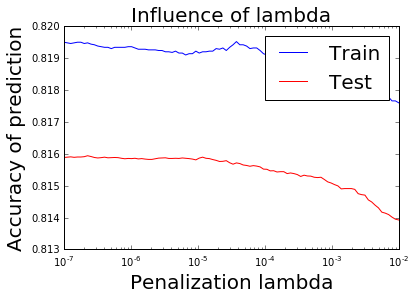

In [4]:
#***** POLYNOMIAL AND FEATURE COMBINATION
#************ POWER 9 **********************

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan = x.copy()
np.putmask(x_nan, x_nan==-999, np.nan)
degree = 9
x_pow9 = np.zeros((x_nan.shape[0], degree*x_nan.shape[1]+53))

#Let's build a matrix using a polynomial basis function (power 5)
for column in range(0,x_nan.shape[1]):
    x_pow9[:, column] = x_nan[:, column]
    for deg in range(1,degree):
        x_pow9[:, column + deg*x_nan.shape[1]] = np.multiply(x_nan[:, column], x_pow9[:, column + (deg-1)*x_nan.shape[1]])
        
x_pow9 = combinations(x_pow9, [0], [1,2,6,7,])
x_pow9 = combinations(x_pow9, [2], [6,7])
x_pow9 = combinations(x_pow9, [3], [6,9,19,21,23,29])
x_pow9 = combinations(x_pow9, [4], [5,6])
x_pow9 = combinations(x_pow9, [5], [6])
x_pow9 = combinations(x_pow9, [6], [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])
x_pow9 = combinations(x_pow9, [9], [10,13,16,19,21,23,26,29])
x_pow9 = combinations(x_pow9, [10], [13,16])
x_pow9 = combinations(x_pow9, [21], [23,26,29])
x_pow9 = combinations(x_pow9, [23], [26,29])
x_pow9 = combinations(x_pow9, [26], [29])

#put back -9 instead of Nan
x_pow9[np.isnan(x_pow9)]=-9

ratio = 0.2
seed = 2
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_pow9, y, ratio, seed)

#tx_train_fifth, m, s = standardize(x_train)
#tx_test_fifth, m, s = standardize(x_test)

tx_train_pow9 = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test_pow9 = np.c_[np.ones((x_test.shape[0], 1)), x_test]
w = np.ones((tx_train_pow9.shape[1], 1))

#calculate accuracy for different lambdas (use cross_validation_ridge() for cross folds)
lambds = np.logspace(-7, -2, 100)
best_f1 = 0
best_lamb = 0
k_folds = 10
seed = 1
f1_tr = []
f1_te = []
for lamb in lambds:
    w_rid, r = ridge_regression(y_train, tx_train_pow9, lamb)
    y_pred_tr = predict_labels(w_rid, tx_train_pow9)
    y_pred_te = predict_labels(w_rid, tx_test_pow9)
    f1_rid_tr = 1-sum(abs(y_train-y_pred_tr))/(2*len(y_pred_tr))
    f1_rid_te = 1-sum(abs(y_test-y_pred_te))/(2*len(y_pred_te))
    f1_tr.append(f1_rid_tr)
    f1_te.append(f1_rid_te)
    if f1_rid_te > best_f1:
        best_lamb = lamb
        best_f1 = f1_rid_te

#Print and plot results
print("the best lmabda is {bl} with {f}".format(bl=best_lamb, f=best_f1))
plt.figure()
plt.semilogx(lambds, f1_tr)
plt.semilogx(lambds, f1_te, color='r')
plt.xlabel("Penalization lambda", fontsize=20)
plt.ylabel("Accuracy of prediction",  fontsize=20)
plt.legend(('Train', 'Test'),  fontsize=20)
plt.title("Influence of lambda", fontsize=20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()



cross folds: ridge
[ 0.815965]
[ 0.815535]
[ 0.81566]
[ 0.81562]
[ 0.81557]
[ 0.81585]
[ 0.815385]
[ 0.815765]
[ 0.815725]
[ 0.81585]


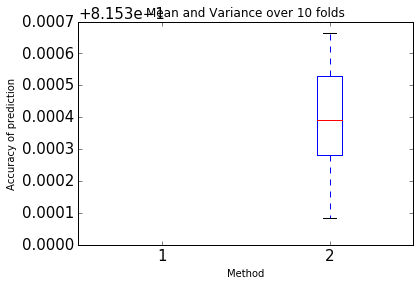

In [5]:
#Cross validation on Ridge and least squares
k_folds = 10

f1, w_CV_rid = cross_validation_ridge(y_train, x_train, best_lamb, k_folds, seed)

f1_CV_rid = []
f1_CV_LS = []
print("cross folds: ridge")
for i in range(0, w_CV_rid.shape[0]):
    y_pred_rid = predict_labels(w_CV_rid[i], tx_test_pow9)
    y_pred_rid = np.reshape(y_pred_rid, (len(y_pred_rid), 1))
    f1_rid = sum(abs(y_test-y_pred_rid))/(2*len(y_pred_rid))
    print(1-f1_rid)
    f1_CV_rid.append(1-f1_rid)

f1_CV_rid = np.reshape(f1_CV_rid, (len(f1_CV_rid), 1))

plt.boxplot([f1_CV_LS, f1_CV_rid])
plt.title('Mean and Variance over 10 folds')
plt.xlabel("Method")
plt.ylabel("Accuracy of prediction")

# Do your thing crazy machine learning thing here :) ...

In [ ]:
#Something is missing

max_iter = 100
threshold = 1e-8
alpha = 0.001
ratio = 0.1
lambd = 0.01
losses = []

y = np.reshape(y, (len(y), 1))


x_train, x_test, y_train, y_test = split_data(x, y_vec, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
w = np.zeros((tx_train.shape[1], 1))

In [ ]:
ratio = 0.1
x_train, x_test, y_train, y_test = split_data(x, y, ratio)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
gamma = 0.001
x_train, x_test, y_train, y_test = split_data(x, y, ratio)
tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
initial_w  = np.zeros((tx_train.shape[1],1))

w, rmse = learning_by_newton_method(y_train, tx_train, initial_w, 100, gamma)
print(rmse)

In [ ]:
max_iter = 10
threshold = 1e-8
#alpha = 0.001
lambd = 0.1
ratio = 0.05
losses = []

gammas = np.logspace(-5, -1, 10)
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x_99, y, ratio)

#tx_train, x_tr_mean, x_tr_std = standardize(x_train)
#tx_test, x_te_mean, x_te_std = standardize(x_test)

tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
for gamma in gammas:
    initial_w  = np.ones((tx_train.shape[1],1))
    w_NM, rmse_NM = learning_by_newton_method(y_train, tx_train, initial_w, max_iter, gamma)
#     lossREG = compute_loss(y_test, tx_test, w)
#     rmse = np.sqrt(2*lossREG)
    losses.append(rmse_NM)

In [ ]:
plt.semilogx(gammas[0:5], losses[0:5], marker=".", color='b')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.grid(True)

In [ ]:
# Was it working? in your version of learning_by_gradient_descent you had to provide max_iters to the function
# just as in my implemetnation

#Lets test some basics: Least Squares Gradient Descent
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 1000
threshold = 1e-8
alpha = 0.002
lambd = 0.001
ratio = 0.1
losses = []

# Initialization
#w_initial = weights

y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x, y, ratio)

#tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
#tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]

tx_train, x_tr_mean, x_tr_std = standardize(x_train)
tx_test, x_te_mean, x_te_std = standardize(x_test)
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_gradient_descent(y_train, tx_train, w, alpha)
    if iter % 20 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
print("The loss={l}".format(l=compute_loss(y_test, tx_test, w)))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
k_fold = 20
seed = 1
lambd = 0.01
max_iters = 5
w_cv, lossTR_cv, lossTE_cv = cross_validation_laz(y, x_99, k_fold, seed, lambd, max_iters)

In [ ]:
# Was it working? in your version of learning_by_newton_method you had to provide max_iters to the function
# just as in my implemetnation

# Define the parameters of the algorithm.
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 100
threshold = 1e-8
alpha = 0.002
lambd = 0.001
ratio = 0.1
losses = []

# Initialization
#w_initial = weights

y_vec = np.zeros((y.shape[0], 1))
y_vec[:,0] = y

x_train, x_test, y_train, y_test = split_data(x, y_vec, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
    if iter % 20 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
print("The loss={l}".format(l=compute_RMSE(y_test, tx_test, w)))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

# PCA

In [ ]:
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 10
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.1
losses = []

eigenvectors, eigenvalues, V = np.linalg.svd(x.T, full_matrices=False)
x_proj = np.dot(x, eigenvectors[:, 0:10])
y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x_proj, y, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
    if iter % 10 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")

mse = compute_loss(y_test, tx_test, w)
rmse = np.sqrt(2*mse)
print("The loss={l}".format(l=rmse))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Newton: execution time={t:.3f} seconds".format(t=exection_time))



# ERROR

In [ ]:
mse = compute_loss(y_test, tx_test, w)
rmse = np.sqrt(2*mse)
print(rmse)

# K-fold

In [ ]:
max_iter = 20
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.1
losses = []
k_fold = 20
seed = 1

#x_train, x_test, y_train, y_test = split_data(x, y, ratio)
#tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
#tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
#w = np.ones((x_train.shape[1]+1, 1))
y = np.reshape(y, (len(y), 1))

w_RegPen, tr_rmse, te_rmse = cross_validation_laz(y, x, k_fold, seed, lambd, max_iter)
print(w_LS.std(axis=0).mean())
print(tr_rmse)
print(te_rmse)

In [ ]:
weights_NM_20folds = w_LS
train_rmse_NM_20folds = tr_rmse
test_rmse_NM_20folds = te_rmse

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

#Let's replace the -999 by Nan to avoid computation while computing the power 3
x_nan_test = X_test.copy()
np.putmask(x_nan_test, x_nan_test==-999, np.nan)
degree = 9
x_TEST = np.zeros((x_nan_test.shape[0], degree*x_nan_test.shape[1]+53))

#Let's build a matrix using a polynomial basis function (power 5)
for column in range(0,x_nan_test.shape[1]):
    x_TEST[:, column] = x_nan_test[:, column]
    for deg in range(1,degree):
        x_TEST[:, column + deg*x_nan_test.shape[1]] = np.multiply(x_nan_test[:, column], x_TEST[:, column + (deg-1)*x_nan_test.shape[1]])
        
x_TEST = combinations(x_TEST, [0], [1,2,6,7,])
x_TEST = combinations(x_TEST, [2], [6,7])
x_TEST = combinations(x_TEST, [3], [6,9,19,21,23,29])
x_TEST = combinations(x_TEST, [4], [5,6])
x_TEST = combinations(x_TEST, [5], [6])
x_TEST = combinations(x_TEST, [6], [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])
x_TEST = combinations(x_TEST, [9], [10,13,16,19,21,23,26,29])
x_TEST = combinations(x_TEST, [10], [13,16])
x_TEST = combinations(x_TEST, [21], [23,26,29])
x_TEST = combinations(x_TEST, [23], [26,29])
x_TEST = combinations(x_TEST, [26], [29])

#put back -9 instead of Nan
x_TEST[np.isnan(x_TEST)]=-9

tx_TEST = np.c_[np.ones((x_TEST.shape[0], 1)), x_TEST]
print(tx_TEST.shape)

In [6]:
weights = w_CV_rid[0]
print(weights.shape)

(377,)


In [ ]:
OUTPUT_PATH = '../data/ridgeA815.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tx_TEST)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
# Delete train.csv such that github accepts push
os.remove('../data/test.csv')